## CNN  en sepecifier une station

In [96]:
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



traite time serise data 

In [104]:
file_path = 'merge_bike_44_weather_data_filtered.csv'
data = pd.read_csv(file_path)
## add caractère time
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

## line comme entre
data = data.set_index('timestamp')



In [110]:


X = data.drop(columns=['available_bikes'])  
y = data['available_bikes']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
#(nombre_station , longgeur de serie , nombre feature)
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))
test_timestamps = data.index[X_test.shape[0] * -1:]  

test_timestamps = test_timestamps[:len(y_test)]

print(X_train.shape)
print(test_timestamps)

(2182, 1, 12)
Index(['2025-01-04 17:30:00', '2025-01-04 17:45:00', '2025-01-04 18:00:00',
       '2025-01-04 18:30:00', '2025-01-04 18:45:00', '2025-01-04 19:00:00',
       '2025-01-04 19:15:00', '2025-01-04 19:30:00', '2025-01-04 19:45:00',
       '2025-01-04 20:00:00',
       ...
       '2025-01-10 10:45:00', '2025-01-10 11:00:00', '2025-01-10 11:15:00',
       '2025-01-10 11:30:00', '2025-01-10 11:45:00', '2025-01-10 12:00:00',
       '2025-01-10 12:15:00', '2025-01-10 12:30:00', '2025-01-10 12:45:00',
       '2025-01-10 13:00:00'],
      dtype='object', name='timestamp', length=546)


definir data et model

In [106]:


model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 1, 16)             208       
                                                                 
 flatten_20 (Flatten)        (None, 16)                0         
                                                                 
 dense_46 (Dense)            (None, 64)                1088      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1361 (5.32 KB)
Trainable params: 1361 (5.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


fit

Training the model...
Epoch 1/10
62/62 [==============================] - 4s 16ms/step - loss: 0.0659 - mae: 0.2048 - val_loss: 0.0441 - val_mae: 0.1750
Epoch 2/10
62/62 [==============================] - 0s 7ms/step - loss: 0.0308 - mae: 0.1421 - val_loss: 0.0227 - val_mae: 0.1179
Epoch 3/10
62/62 [==============================] - 0s 7ms/step - loss: 0.0152 - mae: 0.0959 - val_loss: 0.0114 - val_mae: 0.0802
Epoch 4/10
62/62 [==============================] - 0s 7ms/step - loss: 0.0086 - mae: 0.0720 - val_loss: 0.0071 - val_mae: 0.0656
Epoch 5/10
62/62 [==============================] - 0s 7ms/step - loss: 0.0064 - mae: 0.0625 - val_loss: 0.0065 - val_mae: 0.0644
Epoch 6/10
62/62 [==============================] - 0s 7ms/step - loss: 0.0055 - mae: 0.0583 - val_loss: 0.0061 - val_mae: 0.0635
Epoch 7/10
62/62 [==============================] - 1s 9ms/step - loss: 0.0050 - mae: 0.0555 - val_loss: 0.0057 - val_mae: 0.0621
Epoch 8/10
62/62 [==============================] - 1s 9ms/step - l

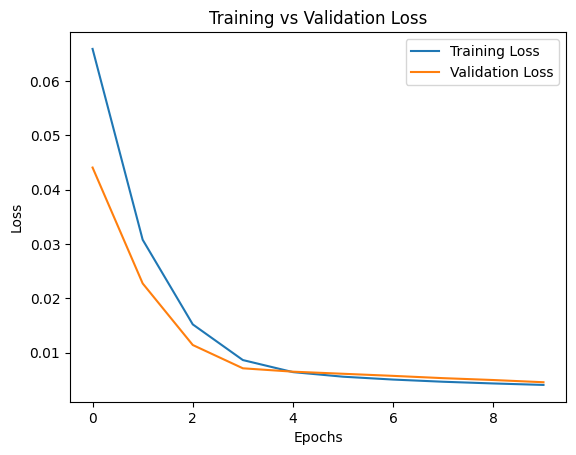

18/18 [==============================] - 0s 3ms/step


In [107]:

print("Training the model...")
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()
predictions = model.predict(X_test)

y_test_original = scaler_y.inverse_transform(y_test) 
y_pred = scaler_y.inverse_transform(predictions)   
total_bike_stands = data['available_bike_stands'] + data['available_bikes']  
total_bike_stands = total_bike_stands.iloc[0]  
y_pred_stands = total_bike_stands - y_pred  
y_test_stands = total_bike_stands - y_test_original 


figure

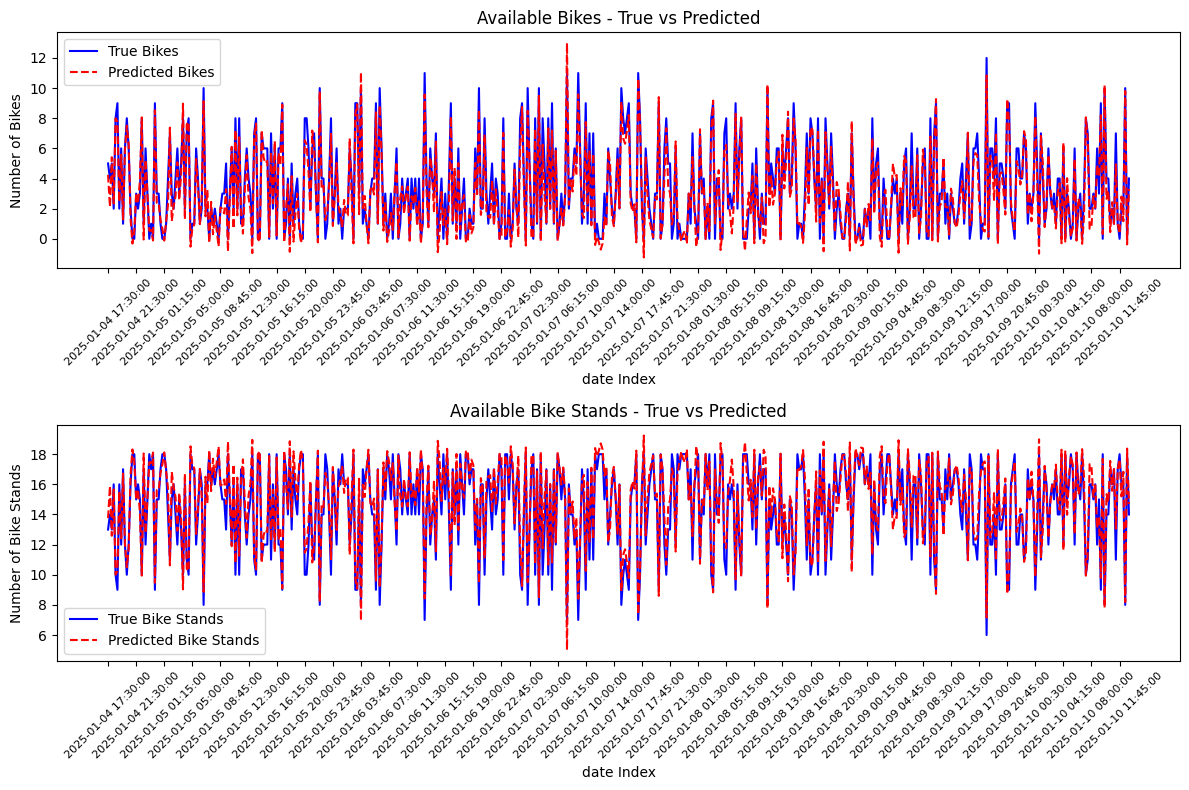

In [114]:

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(test_timestamps,y_test_original, label='True Bikes', color='blue')
plt.plot(test_timestamps,y_pred, label='Predicted Bikes', linestyle='--', color='red')
plt.title('Available Bikes - True vs Predicted')
plt.xlabel('date Index')
plt.ylabel('Number of Bikes')
plt.legend()
plt.xticks(ticks=np.arange(0, len(test_timestamps), step=15), 
           labels=test_timestamps[::15], 
           rotation=45, fontsize=8) 
plt.subplot(2, 1, 2)
plt.plot(test_timestamps,y_test_stands, label='True Bike Stands', color='blue')
plt.plot(test_timestamps,y_pred_stands, label='Predicted Bike Stands', linestyle='--', color='red')
plt.title('Available Bike Stands - True vs Predicted')
plt.xlabel('date Index')
plt.ylabel('Number of Bike Stands')
plt.legend()
plt.xticks(ticks=np.arange(0, len(test_timestamps), step=15), 
           labels=test_timestamps[::15], 
           rotation=45, fontsize=8) 
plt.tight_layout()
plt.show()

In [109]:
print("(",X_train.shape[0],",",X_train.shape[1],",",X_train.shape[2],")")

r2 = r2_score(y_test, predictions)
print("R² Score:", r2)


mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

( 2182 , 1 , 12 )
R² Score: 0.9277079077666353
Mean Absolute Error (MAE): 0.053622817285176955


## CNN  pour toute stations

In [58]:
file_path = 'merge_bikes_filtered_weather_data_filtered.csv'
data = pd.read_csv(file_path)
# prepa de data
data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
data = data.set_index('timestamp')


data_cleaned = data.drop(columns=[])
X = data_cleaned.drop(columns=['available_bikes'])  
y = data_cleaned['available_bikes']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
time_steps=4
X_ts, y_ts = create_time_series_features(X_scaled, y_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_ts, y_ts, test_size=0.2)
#(nombre , 1 , nombre feature)
test_timestamps = data.index[X_test.shape[0] * -1:]  
test_timestamps = test_timestamps[:len(y_test)]
model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')  
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 4, 16)             224       
                                                                 
 conv1d_24 (Conv1D)          (None, 3, 16)             528       
                                                                 
 flatten_15 (Flatten)        (None, 48)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                3136      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 1)               

In [42]:
print("(",X_train.shape[0],",",X_train.shape[1],",",X_train.shape[2],")")

( 913491 , 4 , 13 )


In [59]:
print("Training the model...")

early_stopping = EarlyStopping(
    monitor='val_loss',       
    patience=5,                
    restore_best_weights=True, 
    verbose=1                
)
history=model.fit(X_train, y_train, epochs=30, batch_size=512, validation_split=0.1, shuffle=False,callbacks=[early_stopping] )





Training the model...
Epoch 1/30
1606/1606 [==============================] - 34s 19ms/step - loss: 0.0049 - mae: 0.0508 - val_loss: 0.0039 - val_mae: 0.0454
Epoch 2/30
1606/1606 [==============================] - 32s 20ms/step - loss: 0.0038 - mae: 0.0443 - val_loss: 0.0034 - val_mae: 0.0411
Epoch 3/30
1606/1606 [==============================] - 31s 19ms/step - loss: 0.0033 - mae: 0.0411 - val_loss: 0.0026 - val_mae: 0.0367
Epoch 4/30
1606/1606 [==============================] - 32s 20ms/step - loss: 0.0027 - mae: 0.0374 - val_loss: 0.0022 - val_mae: 0.0337
Epoch 5/30
1606/1606 [==============================] - 32s 20ms/step - loss: 0.0023 - mae: 0.0343 - val_loss: 0.0020 - val_mae: 0.0319
Epoch 6/30
1606/1606 [==============================] - 31s 19ms/step - loss: 0.0019 - mae: 0.0317 - val_loss: 0.0021 - val_mae: 0.0335
Epoch 7/30
1606/1606 [==============================] - 42s 26ms/step - loss: 0.0017 - mae: 0.0299 - val_loss: 0.0021 - val_mae: 0.0344
Epoch 8/30
1606/1606 [====

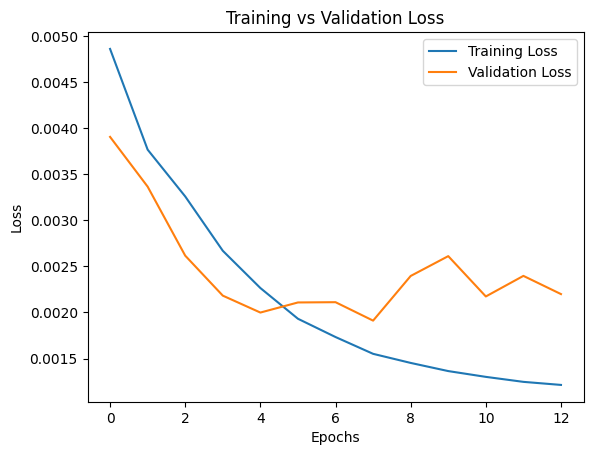

In [60]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [61]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

7137/7137 [==============================] - 24s 3ms/step
R² Score: 0.8448133348178142


predire pour une station

In [63]:
data_test=data.iloc[len(X_train):]
station_data=data_test[data_test['number']==44]
print(station_data.index)
x_station_test=station_data.drop(columns=['available_bikes'])
y_station_test=station_data['available_bikes']


DatetimeIndex(['2025-01-06 23:15:00', '2025-01-06 23:30:00',
               '2025-01-06 23:45:00', '2025-01-07 00:00:00',
               '2025-01-07 00:15:00', '2025-01-07 00:30:00',
               '2025-01-07 00:45:00', '2025-01-07 01:00:00',
               '2025-01-07 01:15:00', '2025-01-07 01:30:00',
               ...
               '2025-01-13 05:45:00', '2025-01-13 06:00:00',
               '2025-01-13 06:15:00', '2025-01-13 06:30:00',
               '2025-01-13 06:45:00', '2025-01-13 07:00:00',
               '2025-01-13 07:15:00', '2025-01-13 07:30:00',
               '2025-01-13 07:45:00', '2025-01-13 08:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=599, freq=None)


7137/7137 [==============================] - 28s 4ms/step


ValueError: x and y must have same first dimension, but have shapes (228373,) and (545, 1)

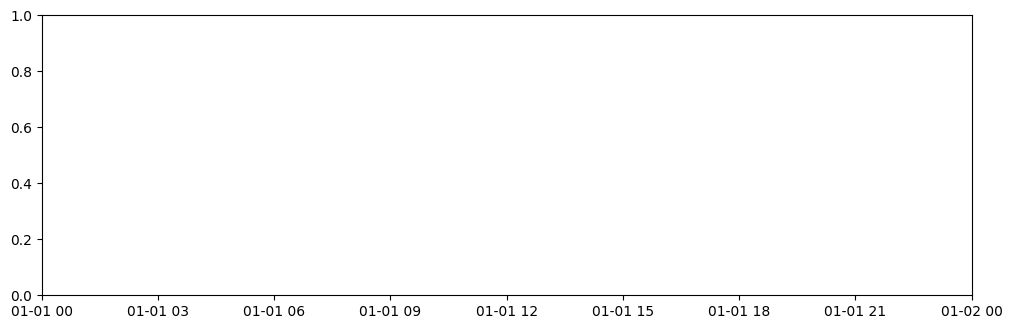

In [52]:




plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(test_timestamps,y_test_original, label='True Bikes', color='blue')
plt.plot(test_timestamps,y_pred, label='Predicted Bikes', linestyle='--', color='red')
plt.title('Available Bikes - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Number of Bikes')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(test_timestamps,y_test_stands, label='True Bike Stands', color='blue')
plt.plot(test_timestamps,y_pred_stands, label='Predicted Bike Stands', linestyle='--', color='red')
plt.title('Available Bike Stands - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Number of Bike Stands')
plt.legend()
plt.tight_layout()
plt.show()

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)
